# Inferring the Distribution of Gravitational Waves

Here we will get the distribution of gravitational wave events in our universe by performing Hierarchical Bayesian Analysis. Here we will reproduce a simpler version of the  population analysis done by the LIGO/VIRGO Collaboration in [this paper](https://arxiv.org/abs/2111.03634)

# Hierarchical Likelihood Inference

In [100]:
import numpy as np
import pandas as pd
import json
import jax.numpy as jnp

with open(f"./event_posterior_samples.json", "r") as f:
    event_samples = {k:pd.DataFrame(v) for k,v in json.load(f).items()}

eventnames = []
posteriors = []
for event, posterior in event_samples.items():
    eventnames.append(event)
    posteriors.append(posterior)

In [63]:
with open(f"./selection_function_samples.json", "r") as f:
    selection_samples = pd.DataFrame(json.load(f))

indices = np.random.randint(0, high=8000, size=2000)

selections_jaxed = {col: jnp.array(selection_samples[col][indices]) for col in selection_samples.columns if col not in ['waveform_name', 'name']}

In [64]:
posteriors_jaxed = [{col: jnp.array(post[col][indices]) for col in post.columns if col not in ['waveform_name']} for post in posteriors]

## Population Model Recap

We use individual event likelihoods to infer the hierarchical model. 
$$
\begin{equation}
p(\Lambda \mid d) \propto p(\Lambda)\prod_i^N \mathcal{L}\left(d_i \mid \Lambda\right)
\end{equation}
$$
where
$$
\begin{equation}
\mathcal{L}\left(d_i \mid \Lambda\right) \propto \int \frac{p\left(\theta \mid d_i\right) p(\theta \mid \Lambda)}{p(\theta)} d \theta \approx 
\left\langle  \frac{p(\theta \mid \Lambda)}{p(\theta)}  \right\rangle_{\sim p\left(\theta \mid d_i\right)}
\end{equation}
$$

We will "recycle" these posteriors and get the result for the following population model:


In [66]:
## Mass model
def power_law(x, L, a, b):
    normalization = (L + 1) / (jnp.power(b, L+1) - jnp.power(a, L+1))
    return jnp.power(x,L) * normalization

def trunc_normal_pdf(x, mu, sig, a, b):
    a_std, b_std = (a - mu) / sig, (b - mu) / sig
    return jax.scipy.stats.truncnorm.pdf(x, a_std, b_std, loc=mu, scale=sig)

In [67]:
class MassModel:
    def __init__(self, m_min, m_max):
        self.m_min = m_min
        self.m_max = m_max

    def pdf(self, data, params):
        p_m_power_law = power_law(data['mass_1_source'], params['lambda'], self.m_min, self.m_max)
        p_m_peak = trunc_normal_pdf(data['mass_1_source'], params['mu_m'], params['sigma_m'], self.m_min, self.m_max)
        p_q = power_law(data['mass_ratio'], params['gamma'], self.m_min/data['mass_1_source'], 1.0)
        p_m = params['fp'] * p_m_power_law + (1 - params['fp']) * p_m_peak
        return p_m*p_q

    def __call__(self, data, params):
        return self.pdf(data, params)

In [68]:
class Redshift:
    def __init__(self, z_max):
        from astropy.cosmology import Planck15
        self.z = jnp.linspace(0,z_max,300)
        self.y = Planck15.differential_comoving_volume(self.z).value * 4 * np.pi
        self.kappas = jnp.linspace(-10,10,3000)
        self._kappa_norms = None

    def dVdz(self, z):
        return jnp.interp(z, self.z, self.y)

    def normalization_func(self, z, kappa):
        return (1 + z)**(kappa - 1) * self.dVdz(z)

    @property
    def kappa_norms(self):
        if self._kappa_norms is None:
            self._normalize()
        return self._kappa_norms

    def _normalize(self):
        self._kappa_norms = jnp.array([jax.scipy.integrate.trapezoid(self.normalization_func(self.z, float(self.kappas[i])), self.z) for i in range(len(self.kappas))])

    def normalization(self, kappa):
        return jnp.interp(kappa, self.kappas, self.kappa_norms)
    
    def __call__(self, data, params):
        un_normalized = self.dVdz(data['redshift']) * ((1 + data['redshift']) ** (params["kappa"]-1))
        return un_normalized#/self.normalization(params['kappa'])

In [69]:
R = Redshift(3.0)
M = MassModel(2.0, 100.0)

In [96]:
class CustomLikelihood:
    def __init__(self, all_posteriors, selections, domain_changer=None):
        self.all_posteriors = all_posteriors
        self.posts = {key: jnp.stack([post[key] for post in self.all_posteriors]) for key in ['mass_1_source', 'mass_ratio', 'redshift', 'prior']};
        self.selections = selections
        self.domain_changer = domain_changer
        self.N_events = len(self.all_posteriors)

    def logpdf(self, x):
        event_likelihoods = jnp.sum( jax.scipy.special.logsumexp( (jnp.log(M(self.posts,x)) + jnp.log(R(self.posts,x)) - jnp.log(self.posts["prior"])) , axis=1) )
        selection_effects = -self.N_events * jax.scipy.special.logsumexp( jnp.log(M(self.selections, x)) + jnp.log(R(self.selections, x)) - jnp.log(self.selections["prior"]) )
        return event_likelihoods + selection_effects

In [97]:
from bayesian_inference import NUTS, MHSampler
import jax

limits = {'lambda' : [-5,2], "gamma": [-3,3], 'fp':[0,1], 'mu_m':[10,50], 'sigma_m':[3,10], 'kappa':[-10,10]}
initial_point = {'lambda' : -2.35, "gamma": 1.1, 'fp':0.1, 'mu_m':33.0, 'sigma_m':4.0, 'kappa':2.9}

In [98]:
CL = CustomLikelihood(posteriors_jaxed, selections_jaxed)

In [74]:
N = NUTS(CL, initial_point, limits=limits)

In [75]:
result = N.run(2000)

Running the inference for 2000 samples


In [76]:
df = pd.DataFrame(result)

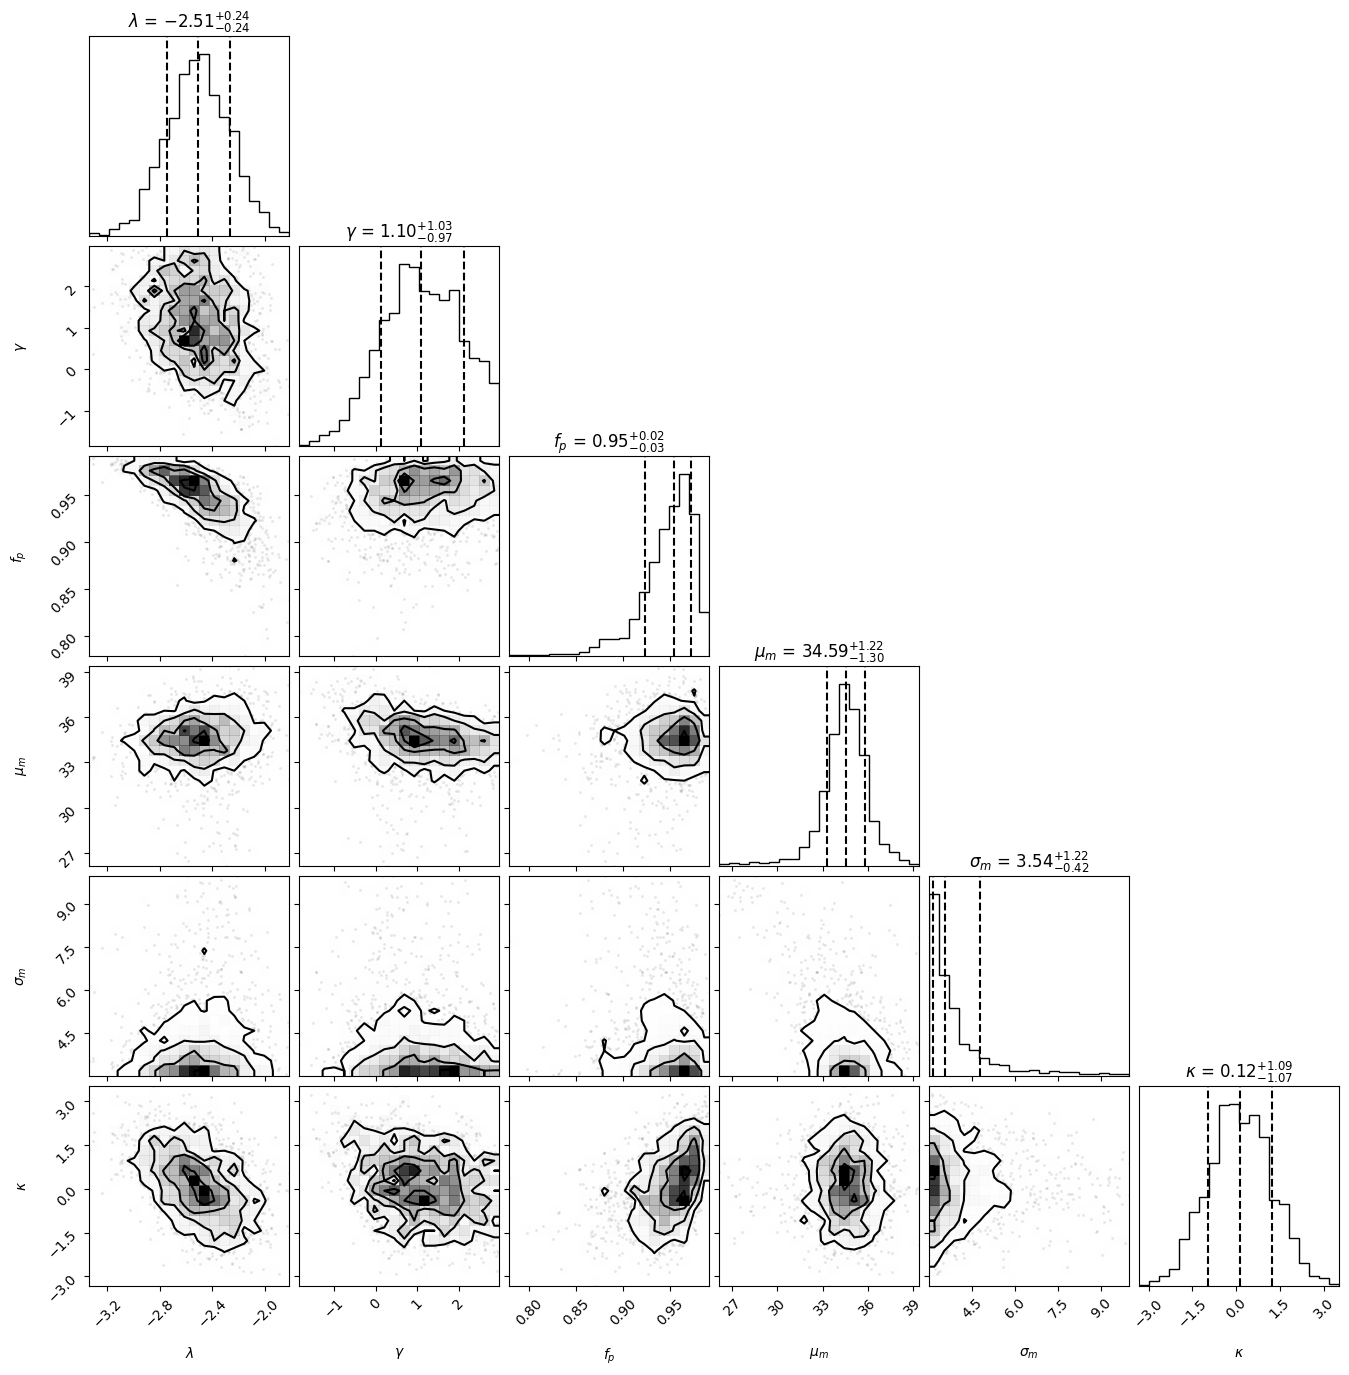

In [79]:
import corner

figure = corner.corner(
    df.values,
    labels=[
        r"$\lambda$",
        r"$\gamma$",
        r"$f_p$",
        r"$\mu_m$",
        r"$\sigma_m$",
        r"$\kappa$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)